#**Hard Parameter Sharing Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AI_VIETNAM/AIO2023/Module 10/Multi-Task-Learning

/content/drive/MyDrive/AI_VIETNAM/AIO2023/Module 10/Multi-Task-Learning


In [ ]:
# raw dataset
!gdown 14EAEMXmd3zs2hIMY63UhHPSFPDAkiTzw

Downloading...
From (original): https://drive.google.com/uc?id=14EAEMXmd3zs2hIMY63UhHPSFPDAkiTzw
From (redirected): https://drive.google.com/uc?id=14EAEMXmd3zs2hIMY63UhHPSFPDAkiTzw&confirm=t&uuid=9369f97b-0dea-4a2b-9e1a-dcf0a85986a2
To: /content/drive/MyDrive/AI_VIETNAM/AIO2023/Module 10/Multi-Task-Learning/data/NYUD_MT.tgz
100% 4.22G/4.22G [00:42<00:00, 99.9MB/s]


In [ ]:
!tar -xvzf NYUD_MT.tgz

In [ ]:
#processed dataset
!unzip nyuv2.zip

##**Dataset**

In [ ]:
import os
import torch
import fnmatch
import numpy as np

class NYUv2(torch.utils.data.dataset.Dataset):
    def __init__(self, root, train=True):
        self.train = train
        self.root = os.path.expanduser(root)

        # read the data file
        if train:
            self.data_path = root + '/train'
        else:
            self.data_path = root + '/val'

        # calculate data length
        self.data_len = len(fnmatch.filter(os.listdir(self.data_path + '/image'), '*.npy'))

    def __getitem__(self, index):
        # load data from the pre-processed npy files
        image = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/image/{:d}.npy'.format(index)), -1, 0))
        semantic = torch.from_numpy(np.load(self.data_path + '/label/{:d}.npy'.format(index)))
        depth = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/depth/{:d}.npy'.format(index)), -1, 0))

        return {
            'image': image.float(),
            'semantic': semantic.float(),
            'depth': depth.float()
        }

    def __len__(self):
        return self.data_len

In [ ]:
data_path = './data/NYUDv2'
train_ds = NYUv2(root=data_path, train=True)
val_ds = NYUv2(root=data_path, train=False)

In [ ]:
len(train_ds) + len(val_ds)

1449

In [ ]:
sample = next(iter(train_ds))

In [ ]:
sample['image'].shape, sample['semantic'].shape, sample['depth'].shape

(torch.Size([3, 288, 384]), torch.Size([288, 384]), torch.Size([1, 288, 384]))

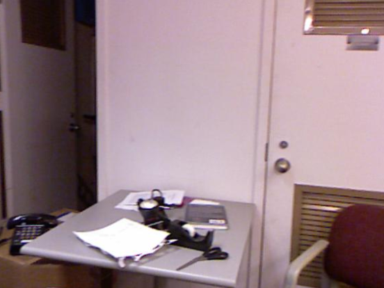

In [ ]:
from PIL import Image
from torchvision import transforms

transform = transforms.ToPILImage()
img = transform(sample['image'])
img

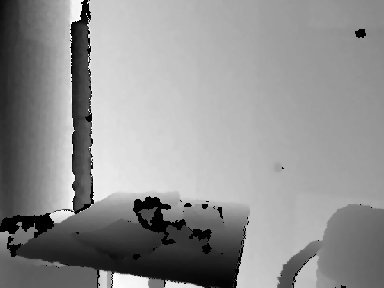

In [ ]:
img = transform(sample['depth'])
img

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

##**Hard Parameter Sharing Model**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class HardParameterSharingModel(nn.Module):
    def __init__(self):
        super(HardParameterSharingModel, self).__init__()
        # initialise network parameters
        filter = [64, 128, 256, 512, 512]

        self.class_nb = 13

        # define encoder decoder layers
        self.encoder_block = nn.ModuleList([self.conv_layer([3, filter[0]])])
        self.decoder_block = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        for i in range(4):
            self.encoder_block.append(self.conv_layer([filter[i], filter[i + 1]]))
            self.decoder_block.append(self.conv_layer([filter[i + 1], filter[i]]))

        # define convolution layer
        self.conv_block_enc = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        self.conv_block_dec = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        for i in range(4):
            if i == 0:
                self.conv_block_enc.append(self.conv_layer([filter[i + 1], filter[i + 1]]))
                self.conv_block_dec.append(self.conv_layer([filter[i], filter[i]]))
            else:
                self.conv_block_enc.append(nn.Sequential(self.conv_layer([filter[i + 1], filter[i + 1]]),
                                                         self.conv_layer([filter[i + 1], filter[i + 1]])))
                self.conv_block_dec.append(nn.Sequential(self.conv_layer([filter[i], filter[i]]),
                                                         self.conv_layer([filter[i], filter[i]])))

        # define task specific layers
        self.pred_task1 = nn.Sequential(nn.Conv2d(in_channels=filter[0], out_channels=filter[0], kernel_size=3, padding=1),
                                        nn.Conv2d(in_channels=filter[0], out_channels=self.class_nb, kernel_size=1, padding=0))
        self.pred_task2 = nn.Sequential(nn.Conv2d(in_channels=filter[0], out_channels=filter[0], kernel_size=3, padding=1),
                                        nn.Conv2d(in_channels=filter[0], out_channels=1, kernel_size=1, padding=0))

        # define pooling and unpooling functions
        self.down_sampling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.up_sampling = nn.MaxUnpool2d(kernel_size=2, stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    # define convolutional block
    def conv_layer(self, channel):
        conv_block = nn.Sequential(
                nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=3, padding=1),
                nn.BatchNorm2d(num_features=channel[1]),
                nn.ReLU(inplace=True)
            )
        return conv_block

    def forward(self, x):
        g_encoder, g_decoder, g_maxpool, g_upsampl, indices = ([0] * 5 for _ in range(5))
        for i in range(5):
            g_encoder[i], g_decoder[-i - 1] = ([0] * 2 for _ in range(2))

        # global shared encoder-decoder network
        for i in range(5):
            if i == 0:
                g_encoder[i][0] = self.encoder_block[i](x)
                g_encoder[i][1] = self.conv_block_enc[i](g_encoder[i][0])
                g_maxpool[i], indices[i] = self.down_sampling(g_encoder[i][1])
            else:
                g_encoder[i][0] = self.encoder_block[i](g_maxpool[i - 1])
                g_encoder[i][1] = self.conv_block_enc[i](g_encoder[i][0])
                g_maxpool[i], indices[i] = self.down_sampling(g_encoder[i][1])

        for i in range(5):
            if i == 0:
                g_upsampl[i] = self.up_sampling(g_maxpool[-1], indices[-i - 1])
                g_decoder[i][0] = self.decoder_block[-i - 1](g_upsampl[i])
                g_decoder[i][1] = self.conv_block_dec[-i - 1](g_decoder[i][0])
            else:
                g_upsampl[i] = self.up_sampling(g_decoder[i - 1][-1], indices[-i - 1])
                g_decoder[i][0] = self.decoder_block[-i - 1](g_upsampl[i])
                g_decoder[i][1] = self.conv_block_dec[-i - 1](g_decoder[i][0])

        # define task prediction layers
        t1_pred = F.log_softmax(self.pred_task1(g_decoder[i][1]), dim=1)
        t2_pred = self.pred_task2(g_decoder[i][1])

        return {
            'semantic': t1_pred,
            'depth': t2_pred
        }

##**Loss**

In [ ]:
def compute_loss(x_pred, x_output, task_type):
    device = x_pred.device

    # binary mark to mask out undefined pixel space
    binary_mask = (torch.sum(x_output, dim=1) != 0).float().unsqueeze(1).to(device)

    if task_type == 'semantic':
        # semantic loss: depth-wise cross entropy
        loss = F.nll_loss(x_pred, x_output, ignore_index=-1)

    if task_type == 'depth':
        # depth loss: l1 norm
        loss = torch.sum(torch.abs(x_pred - x_output) * binary_mask) / torch.nonzero(binary_mask, as_tuple=False).size(0)

    return loss

##**Training**

In [ ]:
from tqdm import tqdm

def train_epoch(train_loader, model, device, optimizer):
    # iteration for all batches
    model.train()
    losses = {'semantic': [], 'depth': [], 'total': []}
    for i, batch in tqdm(enumerate(train_loader)):
        images = batch['image'].to(device)
        semantic = batch['semantic'].long().to(device)
        depth = batch['depth'].to(device)

        output = model(images)

        optimizer.zero_grad()
        train_loss = {
            'semantic': compute_loss(output['semantic'], semantic, 'semantic'),
            'depth': compute_loss(output['depth'], depth, 'depth')
        }

        loss = train_loss['semantic'] + train_loss['depth']

        loss.backward()
        optimizer.step()

        losses['semantic'].append(train_loss['semantic'].item())
        losses['depth'].append(train_loss['depth'].item())
        losses['total'].append(loss.item())

    avg_losses = {task: sum(task_loss)/len(task_loss) for task, task_loss in losses.items()}

    return avg_losses


def evaluation_epoch(val_loader, model, device):
    # iteration for all batches
    model.eval()
    losses = {'semantic': [], 'depth': [], 'total':[]}
    with torch.no_grad():
        for i, batch in tqdm(enumerate(val_loader)):
            images = batch['image'].to(device)
            semantic = batch['semantic'].long().to(device)
            depth = batch['depth'].to(device)

            output = model(images)

            train_loss = {
                'semantic': compute_loss(output['semantic'], semantic, 'semantic'),
                'depth': compute_loss(output['depth'], depth, 'depth')
            }

            loss = train_loss['semantic'] + train_loss['depth']

            losses['semantic'].append(train_loss['semantic'].item())
            losses['depth'].append(train_loss['depth'].item())
            losses['total'].append(loss.item())

    avg_losses = {task: sum(task_loss)/len(task_loss) for task, task_loss in losses.items()}
    return avg_losses

def train(train_loader, val_loader, model, device, optimizer, epochs):
    best_loss = 100.
    for epoch in range(epochs):
        train_loss = train_epoch(train_loader, model, device, optimizer)
        val_loss = train_epoch(train_loader, model, device, optimizer)
        scheduler.step()
        if val_loss['total'] < best_loss:
            best_loss = val_loss['total']
            torch.save(model.state_dict(), './model/hard_parameter_sharing_model_weights.pth')
            print(f"Model save: ./model/soft_parameter_sharing_model_weights.pth")
        print('Epoch: {:04d} | Train: Semantic Loss {:.4f} - Depth Loss {:.4f} - Total Loss {:.4f} ||'
            'Eval: Semantic Loss {:.4f} - Depth Loss {:.4f} - Total Loss {:.4f} '
            .format(epoch+1, train_loss['semantic'], train_loss['depth'], train_loss['total'],
                    val_loss['semantic'], val_loss['depth'], val_loss['total']))
    return model

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HardParameterSharingModel()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

25055185

In [ ]:
samples = next(iter(train_loader))

In [ ]:
with torch.no_grad():
    output = model(samples['image'].to(device))

In [ ]:
compute_loss(output['semantic'], samples['semantic'].long().to(device), 'semantic')

tensor(2.8253, device='cuda:0')

In [ ]:
compute_loss(output['depth'], samples['depth'].long().to(device), 'depth')

tensor(4.2738, device='cuda:0')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
epochs = 10

model = train(train_loader, val_loader, model, device, optimizer, epochs)

100it [01:22,  1.21it/s]
100it [01:21,  1.23it/s]


Epoch: 0001 | Train: Semantic Loss 0.1207 - Depth Loss 0.2244 - Total Loss 0.3451 - Semantic IU 0.9006 - Semantic ACC 0.9609 - Depth ABS 0.2244 ||Eval: Semantic Loss 0.1461 - Depth Loss 0.2252 - Total Loss 0.3713 - Semantic IU 0.8858 - Semantic ACC 0.9517 - Depth ABS 0.2252 


100it [01:21,  1.22it/s]
100it [01:20,  1.24it/s]


Epoch: 0002 | Train: Semantic Loss 0.1031 - Depth Loss 0.2193 - Total Loss 0.3224 - Semantic IU 0.9140 - Semantic ACC 0.9661 - Depth ABS 0.2193 ||Eval: Semantic Loss 0.0735 - Depth Loss 0.2151 - Total Loss 0.2886 - Semantic IU 0.9378 - Semantic ACC 0.9757 - Depth ABS 0.2151 


100it [01:21,  1.23it/s]
100it [01:20,  1.24it/s]


Epoch: 0003 | Train: Semantic Loss 0.0733 - Depth Loss 0.2133 - Total Loss 0.2866 - Semantic IU 0.9382 - Semantic ACC 0.9759 - Depth ABS 0.2133 ||Eval: Semantic Loss 0.0697 - Depth Loss 0.2073 - Total Loss 0.2770 - Semantic IU 0.9416 - Semantic ACC 0.9769 - Depth ABS 0.2073 


100it [01:21,  1.23it/s]
100it [01:20,  1.24it/s]


Epoch: 0004 | Train: Semantic Loss 0.0682 - Depth Loss 0.2093 - Total Loss 0.2775 - Semantic IU 0.9430 - Semantic ACC 0.9774 - Depth ABS 0.2093 ||Eval: Semantic Loss 0.0668 - Depth Loss 0.2085 - Total Loss 0.2753 - Semantic IU 0.9441 - Semantic ACC 0.9780 - Depth ABS 0.2085 


100it [01:21,  1.23it/s]
100it [01:21,  1.23it/s]


Epoch: 0005 | Train: Semantic Loss 0.0683 - Depth Loss 0.1952 - Total Loss 0.2636 - Semantic IU 0.9425 - Semantic ACC 0.9773 - Depth ABS 0.1952 ||Eval: Semantic Loss 0.0649 - Depth Loss 0.1852 - Total Loss 0.2502 - Semantic IU 0.9437 - Semantic ACC 0.9784 - Depth ABS 0.1852 


100it [01:21,  1.22it/s]
100it [01:21,  1.23it/s]


Epoch: 0006 | Train: Semantic Loss 0.0625 - Depth Loss 0.1917 - Total Loss 0.2542 - Semantic IU 0.9459 - Semantic ACC 0.9791 - Depth ABS 0.1917 ||Eval: Semantic Loss 0.0608 - Depth Loss 0.1919 - Total Loss 0.2527 - Semantic IU 0.9480 - Semantic ACC 0.9795 - Depth ABS 0.1919 


100it [01:21,  1.23it/s]
100it [01:20,  1.24it/s]


Epoch: 0007 | Train: Semantic Loss 0.0664 - Depth Loss 0.2131 - Total Loss 0.2795 - Semantic IU 0.9429 - Semantic ACC 0.9777 - Depth ABS 0.2131 ||Eval: Semantic Loss 0.0617 - Depth Loss 0.1981 - Total Loss 0.2598 - Semantic IU 0.9456 - Semantic ACC 0.9793 - Depth ABS 0.1981 


100it [01:21,  1.23it/s]
100it [01:21,  1.23it/s]


Epoch: 0008 | Train: Semantic Loss 0.0599 - Depth Loss 0.1885 - Total Loss 0.2483 - Semantic IU 0.9483 - Semantic ACC 0.9798 - Depth ABS 0.1885 ||Eval: Semantic Loss 0.0632 - Depth Loss 0.2063 - Total Loss 0.2694 - Semantic IU 0.9458 - Semantic ACC 0.9789 - Depth ABS 0.2063 


100it [01:21,  1.23it/s]
100it [01:21,  1.23it/s]


Epoch: 0009 | Train: Semantic Loss 0.0752 - Depth Loss 0.2016 - Total Loss 0.2769 - Semantic IU 0.9338 - Semantic ACC 0.9752 - Depth ABS 0.2016 ||Eval: Semantic Loss 0.0736 - Depth Loss 0.1944 - Total Loss 0.2680 - Semantic IU 0.9371 - Semantic ACC 0.9755 - Depth ABS 0.1944 


100it [01:21,  1.23it/s]
100it [01:20,  1.24it/s]

Epoch: 0010 | Train: Semantic Loss 0.1221 - Depth Loss 0.2097 - Total Loss 0.3319 - Semantic IU 0.9010 - Semantic ACC 0.9602 - Depth ABS 0.2097 ||Eval: Semantic Loss 0.1008 - Depth Loss 0.2080 - Total Loss 0.3088 - Semantic IU 0.9170 - Semantic ACC 0.9668 - Depth ABS 0.2080 


##**Inference**

In [ ]:
model_path = './model/hard_parameter_sharing_model_weights.pth'
model = HardParameterSharingModel()
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device)

In [ ]:
test_sample = next(iter(val_ds))
test_sample = {task: test_sample[task].unsqueeze(0).to(device) for task in test_sample.keys()}

In [ ]:
test_sample['image'].shape

torch.Size([1, 3, 288, 384])

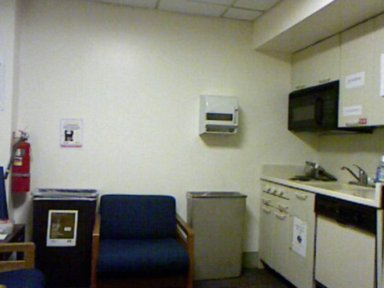

In [ ]:
img = transform(test_sample['image'][0])
img

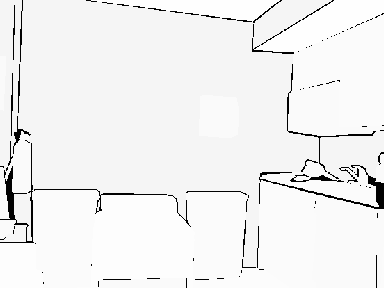

In [ ]:
img = transform(test_sample['semantic'][0])
img

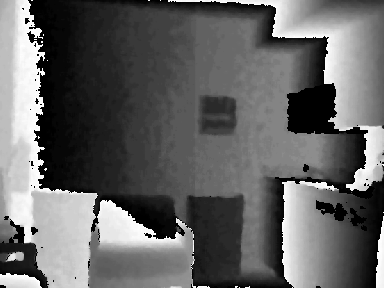

In [ ]:
img = transform(test_sample['depth'][0])
img

In [ ]:
with torch.no_grad():
    output = model(test_sample['image'])

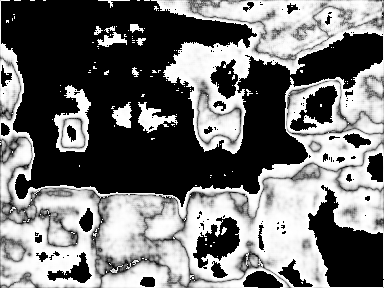

In [ ]:
img = transform(torch.max(output['semantic'][0], dim=0).values)
img